In [202]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [1662]:
test = pd.read_csv('mf_geo_test.csv')
train = pd.read_csv('mf_geo_train.csv')

In [1663]:
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704
421,uNw6t6xk,37.586825,55.794233,-0.002397
422,Ap42ei8k,37.678790,55.772910,-0.910019
423,rn9A8r62,37.752130,55.619640,-0.326547


In [1664]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


In [1665]:
train = pd.concat([train, test])

In [1666]:
train = train.reset_index()

In [1120]:
! pip install geopandas



# ***Определяем в каком городе магазин:***



In [1653]:
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon

In [1667]:
train['geometry'] = [Point(x,y) for x,y in zip (train.lon, train.lat)]

In [1668]:
train = gpd.GeoDataFrame(train)

In [1669]:
region = gpd.read_file('Regions.geojson')

In [1670]:
region

,NAME,ADM3_NAME,geometry
0,Курганская область,Уральский федеральный округ,"MULTIPOLYGON (((61.96619 55.03031, 61.99005 55..."
1,Архангельская область,Северо-Западный федеральный округ,"MULTIPOLYGON (((37.28999 63.88848, 37.29309 63..."
2,Ненецкий автономный округ,Северо-Западный федеральный округ,"MULTIPOLYGON (((53.92590 67.98348, 53.92736 67..."
3,Новгородская область,Северо-Западный федеральный округ,"MULTIPOLYGON (((29.61796 58.25263, 29.62738 58..."
4,Курская область,Центральный федеральный округ,"MULTIPOLYGON (((34.08077 51.66570, 34.08434 51..."
...,...,...,...
78,Хабаровский край,Дальневосточный федеральный округ,"MULTIPOLYGON (((136.44575 54.62850, 136.43675 ..."
79,Еврейская автономная область,Дальневосточный федеральный округ,"MULTIPOLYGON (((130.52108 48.61560, 130.52315 ..."
80,Амурская область,Дальневосточный федеральный округ,"MULTIPOLYGON (((119.65539 56.75703, 119.65620 ..."
81,Иркутская область,Сибирский федеральный округ,"MULTIPOLYGON (((95.64703 54.29784, 95.64770 54..."


In [1671]:
new_train = gpd.sjoin(train, region[['NAME','geometry']], how="left", op="within")

In [1673]:
new_train

,index,point_id,lon,lat,target,geometry,index_right,NAME
0,0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),41,Москва
1,1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),41,Москва
2,2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),39,Ростовская область
3,3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),41,Москва
4,4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),41,Москва
...,...,...,...,...,...,...,...,...
527,102,y8oQuX5v,30.353777,60.049792,0.009100,POINT (30.35378 60.04979),44,Санкт-Петербург
528,103,4nmfqUw0,92.928927,56.116262,0.009100,POINT (92.92893 56.11626),68,Красноярский край
529,104,N9O45mAh,93.015993,56.023697,0.009100,POINT (93.01599 56.02370),68,Красноярский край
530,105,h2InCLKa,30.381172,59.871149,0.009100,POINT (30.38117 59.87115),44,Санкт-Петербург


# ***Москва***

In [1676]:
train_msk = new_train[new_train['NAME'] == 'Москва']
centre = Point(37.6174943, 55.7504461)
for i in train_msk['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

**Определяем метоположение относительно метро**

In [1678]:
metro_msk = gpd.read_file('railways.geojson')

In [1679]:
for i in range(new_train.shape[0]):    
    new_train.loc[i, 'Buffer_500m'] = new_train.loc[i, 'geometry'].buffer(0.005)

In [1680]:
for i in range(new_train.shape[0]):    
    new_train.loc[i, 'Buffer_1.5km'] = new_train.loc[i, 'geometry'].buffer(0.015)

Метро на расстояние 500 м

In [1681]:
train_msk = new_train[new_train['NAME'] == 'Москва']
key = ['point_id', 'Buffer_500m']
train_msk = train_msk[key]
train_msk = train_msk.rename(columns = {'Buffer_500m': 'geometry'})
train_msk['index'] = train_msk.index
train_msk = gpd.GeoDataFrame(train_msk)
 
some = gpd.sjoin(train_msk, metro_msk[['name', 'geometry']], how='left')
some = some.groupby('index')['name'].count()

In [1682]:
some = pd.DataFrame(some)
some = some[some['name'] != 0]

In [1683]:
new_train.loc[some.index, 'near_metro'] = 1

In [1684]:
new_train

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro
0,0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),41,Москва,0.101754,"POLYGON ((37.595776 55.84863000000001, 37.5957...","POLYGON ((37.605776 55.84863000000001, 37.6057...",1.0
1,1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),41,Москва,0.166716,"POLYGON ((37.78921 55.750271, 37.7891859236333...","POLYGON ((37.79921 55.750271, 37.7991377709000...",1.0
2,2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),39,Ростовская область,NaN,"POLYGON ((39.640721 47.21333, 39.6406969236333...","POLYGON ((39.650721 47.21333, 39.6506487709000...",NaN
3,3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),41,Москва,0.092623,"POLYGON ((37.70957 55.78202, 37.70954592363336...","POLYGON ((37.71957 55.78202, 37.71949777090008...",1.0
4,4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),41,Москва,0.033347,"POLYGON ((37.648983 55.730188, 37.648958923633...","POLYGON ((37.658983 55.730188, 37.658910770900...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
527,102,y8oQuX5v,30.353777,60.049792,0.009100,POINT (30.35378 60.04979),44,Санкт-Петербург,NaN,"POLYGON ((30.358777 60.049792, 30.358752923633...","POLYGON ((30.368777 60.049792, 30.368704770900...",NaN
528,103,4nmfqUw0,92.928927,56.116262,0.009100,POINT (92.92893 56.11626),68,Красноярский край,NaN,"POLYGON ((92.933927 56.116262, 92.933902923633...","POLYGON ((92.943927 56.116262, 92.943854770900...",NaN
529,104,N9O45mAh,93.015993,56.023697,0.009100,POINT (93.01599 56.02370),68,Красноярский край,NaN,"POLYGON ((93.02099299999999 56.023697, 93.0209...","POLYGON ((93.030993 56.023697, 93.030920770900...",NaN
530,105,h2InCLKa,30.381172,59.871149,0.009100,POINT (30.38117 59.87115),44,Санкт-Петербург,NaN,"POLYGON ((30.386172 59.871149, 30.386147923633...","POLYGON ((30.396172 59.871149, 30.396099770900...",NaN


Метро на расстояние 1.5 км

In [1685]:
train_msk = new_train[new_train['NAME'] == 'Москва']

In [1686]:
key = ['point_id','Buffer_1.5km']
train_msk = train_msk.loc[:, key]

In [1687]:
train_msk['geometry'] = train_msk['Buffer_1.5km']

In [1688]:
train_msk = train_msk.drop('Buffer_1.5km', axis = 1)

In [1689]:
train_msk = gpd.GeoDataFrame(train_msk)

In [1690]:
key = ['name', 'geometry']
metro_msk = metro_msk[key]
metro_msk = gpd.GeoDataFrame(metro_msk)

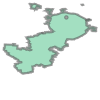

In [1691]:
inner = some_train_msk.loc[0, 'geometry']
outer = region.loc[41, 'geometry']
outer.difference(inner)

In [1692]:
metro_msk.head(2)

,name,geometry
0,None,"POLYGON ((37.66092 55.75845, 37.66084 55.75861..."
1,Калошино,"POLYGON ((37.75953 55.81493, 37.75958 55.81496..."


In [1693]:
metro_msk['index_right'] = metro_msk.index

In [1694]:
some = gpd.sjoin(train_msk, metro_msk[['name', 'geometry']], how='left')

In [1695]:
some = pd.merge(some, metro_msk, how="left", on=["index_right"])

In [1696]:
key = ['geometry_x', 'name_y']
some = some.drop(key, axis = 1)
some = some.rename(columns = {'name_x':'name', 'geometry_y':'geometry_metro'})
some

,point_id,index_right,name,geometry_metro
0,ommNZCUV,136.0,Владыкино,POINT (37.58997 55.84719)
1,ommNZCUV,167.0,Владыкино-Московское,POINT (37.59627 55.84728)
2,nMe2LHPb,44.0,Перово,POINT (37.78648 55.75120)
3,0t2jNYdz,274.0,Электрозаводская,POINT (37.70284 55.78056)
4,0t2jNYdz,24.0,Электрозаводская,POINT (37.70380 55.78171)
...,...,...,...,...
504,f91ZeyYl,154.0,Братиславская,POINT (37.75067 55.65974)
505,BEh6jJ04,137.0,Воробьёвы горы,POINT (37.55931 55.71032)
506,BEh6jJ04,80.0,Спортивная,POINT (37.56421 55.72338)
507,BEh6jJ04,81.0,Фрунзенская,POINT (37.57857 55.72691)


In [1697]:
key = ['point_id', 'geometry']
some = pd.merge(some, new_train.loc[:, key], how="left", on=["point_id"])

In [1698]:
some = some.rename(columns = {'geometry':'geometry_point'})

In [1699]:
some.head(2)

,point_id,index_right,name,geometry_metro,geometry_point
0,ommNZCUV,136.0,Владыкино,POINT (37.58997 55.84719),POINT (37.59078 55.84863)
1,ommNZCUV,167.0,Владыкино-Московское,POINT (37.59627 55.84728),POINT (37.59078 55.84863)


In [1700]:
new_some = some.groupby('point_id')['name'].count()

In [1701]:
new_some = pd.DataFrame(new_some)

In [1702]:
new_some

,name
point_id,
09nncz2H,2
0eSE1PRt,1
0t2jNYdz,2
0yC9gVuF,1
1MZSTvdD,1
...,...
yLT4AAE2,1
yyX5XM5Y,1
zT71jR4g,0


In [1703]:
new_train = pd.merge(new_train, new_some, how="left", on=["point_id"])

In [1704]:
new_train['metro_number'] = new_train['name']
new_train = new_train.drop('name', axis = 1)

Расстояние до метро:

In [1705]:
some_new = some.dropna()

In [1706]:
key = ['geometry_point' , 'geometry_metro']
for i in set(some_new['point_id']):
    one = some_new.loc[some_new['point_id'] == i, key].reset_index()
    dist = np.zeros(one.shape[0])
    for j in range(one.shape[0]):
        dist[j] = one.loc[j, 'geometry_point'].distance(one.loc[j, 'geometry_metro'])
        new_train.loc[new_train['point_id'] == i, 'dist_to_metro'] = np.sort(dist)[0]

In [1707]:
new_train.head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro
0,0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),41,Москва,0.101754,"POLYGON ((37.595776 55.84863000000001, 37.5957...","POLYGON ((37.605776 55.84863000000001, 37.6057...",1.0,2.0,0.001646
1,1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),41,Москва,0.166716,"POLYGON ((37.78921 55.750271, 37.7891859236333...","POLYGON ((37.79921 55.750271, 37.7991377709000...",1.0,1.0,0.002454


**Amenity**

In [204]:
! pip install

In [1356]:
import overpass

api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")

In [1708]:
lon_min = 36.8811
lat_min = 55.4220
lon_max = 38.3780
lat_max = 56.0268

moscow_bbox = lat_min,lon_min,lat_max,lon_max

In [1709]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*moscow_bbox)

In [1359]:
import requests

In [1710]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

In [1711]:
for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']

In [1712]:
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)

In [1713]:
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1862]:
amenity_osm.amenity.value_counts()[:20]

pharmacy           260
waste_disposal     166
bank               163
cafe               151
drinking_water     150
bench              143
bicycle_parking    125
atm                123
post_office         78
telephone           77
fast_food           68
restaurant          58
fuel                57
car_wash            50
doctors             38
parking             35
police              30
dentist             29
clinic              26
library             26
Name: amenity, dtype: int64

In [1715]:
cafe = amenity_osm[amenity_osm['amenity'] == 'cafe']
cafe['Buffer_500m'] = cafe['geometry']
cafe = gpd.GeoDataFrame(cafe)

key = ['point_id', 'Buffer_500m']
left_amen = new_train[key]
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']
amen = gpd.sjoin(left_amen, cafe, how='left')
amen = amen.groupby('point_id')['amenity'].count()

new_train = pd.merge(new_train, amen, how="left", on=["point_id"])
new_train = new_train.rename(columns = {'amenity': 'cafe'})

In [1716]:
pharmacy = amenity_osm[amenity_osm['amenity'] == 'pharmacy']
pharmacy['Buffer_500m'] = pharmacy['geometry']
pharmacy = gpd.GeoDataFrame(pharmacy)

key = ['point_id', 'Buffer_500m']
left_amen = new_train[key]
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']
amen = gpd.sjoin(left_amen, pharmacy, how='left')
amen = amen.groupby('point_id')['amenity'].count()
amen

point_id
09nncz2H    14
0BYKB88d     0
0dALVmD0     0
0eSE1PRt     0
0t2jNYdz    10
            ..
zq24zBHA     0
zqxBvgo3     6
zrqrRf0q     0
zynEGrYK     0
zzmWckqN     0
Name: amenity, Length: 532, dtype: int64

In [1717]:
new_train = pd.merge(new_train, amen, how="left", on=["point_id"])
new_train = new_train.rename(columns = {'amenity': 'pharmacy'})

In [1718]:
bank = amenity_osm[amenity_osm['amenity'] == 'bank']
bank['Buffer_500m'] = bank['geometry']
bank = gpd.GeoDataFrame(bank)

key = ['point_id', 'Buffer_500m']
left_amen = new_train[key]
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']
amen = gpd.sjoin(left_amen, bank, how='left')
amen = amen.groupby('point_id')['amenity'].count()

new_train = pd.merge(new_train, amen, how="left", on=["point_id"])
new_train = new_train.rename(columns = {'amenity': 'bank'})

In [1719]:
post_office = amenity_osm[amenity_osm['amenity'] == 'post_office']
post_office['Buffer_500m'] = bank['geometry']
post_office = gpd.GeoDataFrame(post_office)

key = ['point_id', 'Buffer_500m']
left_amen = new_train[key]
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']
amen = gpd.sjoin(left_amen, post_office, how='left')
amen = amen.groupby('point_id')['amenity'].count()

new_train = pd.merge(new_train, amen, how="left", on=["point_id"])
new_train = new_train.rename(columns = {'amenity': 'post_office'})

In [1720]:
new_train['near_metro'].value_counts()

1.0    137
Name: near_metro, dtype: int64

# ***Питер***

**Amenity**

In [1721]:
lon_min = 29.6170
lat_min = 59.6675
lon_max = 31.1139
lat_max = 60.1556

sp_bbox = lat_min,lon_min,lat_max,lon_max

In [1722]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*sp_bbox)

In [1723]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

In [1724]:
for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1727]:
train_spb = new_train[new_train['NAME'] == 'Санкт-Петербург']
key = ['point_id', 'Buffer_500m']
train_spb = train_spb[key]

In [1728]:
left_amen = train_spb
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1729]:
pharmacy = amenity_osm[amenity_osm['amenity'] == 'pharmacy']
pharmacy['Buffer_500m'] = pharmacy['geometry']
pharmacy = gpd.GeoDataFrame(pharmacy)

amen = gpd.sjoin(left_amen, pharmacy, how='left')
amen = amen.groupby('point_id')['amenity'].count()

j = 0
for i in amen.index:
    new_train.loc[new_train['point_id']== i, 'pharmacy'] = amen.values[j]
    j += 1

In [1730]:
cafe = amenity_osm[amenity_osm['amenity'] == 'cafe']
cafe['Buffer_500m'] = cafe['geometry']
cafe = gpd.GeoDataFrame(cafe)

amen = gpd.sjoin(left_amen, cafe, how='left')
amen = amen.groupby('point_id')['amenity'].count()

j = 0
for i in amen.index:
    new_train.loc[new_train['point_id']== i, 'cafe'] = amen.values[j]
    j += 1

In [1731]:
bank = amenity_osm[amenity_osm['amenity'] == 'bank']
bank['Buffer_500m'] = bank['geometry']
bank = gpd.GeoDataFrame(bank)

amen = gpd.sjoin(left_amen, bank, how='left')
amen = amen.groupby('point_id')['amenity'].count()

j = 0
for i in amen.index:
    new_train.loc[new_train['point_id']== i, 'bank'] = amen.values[j]
    j += 1

In [1732]:
post_office = amenity_osm[amenity_osm['amenity'] == 'post_office']
post_office['Buffer_500m'] = post_office['geometry']
post_office = gpd.GeoDataFrame(post_office)

amen = gpd.sjoin(left_amen, post_office, how='left')
amen = amen.groupby('point_id')['amenity'].count()

j = 0
for i in amen.index:
    new_train.loc[new_train['point_id']== i, 'post_office'] = amen.values[j]
    j += 1

In [1733]:
new_train[new_train['NAME'] == 'Санкт-Петербург'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
6,6,O3tOF6uE,30.468500,59.921400,-1.039679,POINT (30.46850 59.92140),44,Санкт-Петербург,0.153254,"POLYGON ((30.4735 59.9214, 30.47347592363336 5...","POLYGON ((30.4835 59.9214, 30.48342777090008 5...",NaN,NaN,NaN,2,2,11,0
20,20,wQOQvE03,30.579832,59.735526,-1.126119,POINT (30.57983 59.73553),44,Санкт-Петербург,0.332835,"POLYGON ((30.584832 59.735526, 30.584807923633...","POLYGON ((30.594832 59.735526, 30.594759770900...",NaN,NaN,NaN,1,1,1,0


In [1734]:
new_train['NAME'].value_counts()

Москва                              201
Санкт-Петербург                     104
Самарская область                    34
Новосибирская область                33
Республика Татарстан (Татарстан)     32
Свердловская область                 27
Ростовская область                   26
Нижегородская область                26
Красноярский край                    25
Республика Башкортостан              24
Name: NAME, dtype: int64

In [1735]:
train_spb = new_train[new_train['NAME'] == 'Санкт-Петербург']
centre = Point(30.3162290, 59.9387320)
for i in train_spb['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

**Метро Питер**

In [1736]:
metro_spb = gpd.read_file('metro_spb.geojson')
key = ['name', 'geometry']
metro_spb = metro_spb[key]
metro_spb

,name,geometry
0,Цветочная,"POLYGON ((30.33430 59.88697, 30.33446 59.88723..."
1,Полюстрово,"POLYGON ((30.44491 59.96727, 30.44492 59.96713..."
2,Кушелевка,POINT (30.35477 59.99046)
3,Пискарёвка,POINT (30.42501 59.98820)
4,Санкт-Петербург - Финляндский,POINT (30.35816 59.95818)
...,...,...
102,Проспект Просвещения,POINT (30.33290 60.04942)
103,Комендантский проспект,POINT (30.25648 60.01032)
104,Предпортовая,POINT (30.29023 59.83278)
105,Волковская,POINT (30.36120 59.89547)


In [1737]:
train_spb = new_train[new_train['NAME'] == 'Санкт-Петербург']
key = ['point_id', 'Buffer_1.5km']
train_spb = train_spb[key]
train_spb = train_spb.rename(columns = {'Buffer_1.5km': 'geometry'})
train_spb['index'] = train_spb.index
train_spb = gpd.GeoDataFrame(train_spb)
 
some = gpd.sjoin(train_spb, metro_spb[['name', 'geometry']], how='left')
some = some.groupby('index')['name'].count().reset_index()

In [1738]:
key = some['index'].values
new_train.loc[key, 'metro_number'] = some['name'].values

In [1739]:
train_spb = new_train[new_train['NAME'] == 'Санкт-Петербург']
key = ['point_id', 'Buffer_500m']
train_spb = train_spb[key]
train_spb = train_spb.rename(columns = {'Buffer_500m': 'geometry'})
train_spb['index'] = train_spb.index
train_spb = gpd.GeoDataFrame(train_spb)
 
some = gpd.sjoin(train_spb, metro_spb[['name', 'geometry']], how='left')
some = some.groupby('index')['name'].count()

In [1740]:
new_train['near_metro'].value_counts()

1.0    137
Name: near_metro, dtype: int64

In [1741]:
some = pd.DataFrame(some)
some[some['name'] != 0]

,name
index,
6,1
22,1
42,1
64,1
71,1
...,...
521,1
522,3
523,1


In [1742]:
some = pd.DataFrame(some)
some = some[some['name'] != 0]

In [1743]:
new_train.loc[some.index, 'near_metro'] = 1

In [1744]:
new_train['near_metro'].value_counts()

1.0    201
Name: near_metro, dtype: int64

Расстояние до метро:

In [1745]:
metro_spb['index_right'] = metro_spb.index

In [1746]:
train_spb = new_train[new_train['NAME'] == 'Санкт-Петербург']
key = ['point_id', 'Buffer_1.5km']
train_spb = train_spb[key]
train_spb = train_spb.rename(columns = {'Buffer_1.5km': 'geometry'})
train_spb = gpd.GeoDataFrame(train_spb)

In [1747]:
some = gpd.sjoin(train_spb, metro_spb[['name', 'geometry']], how='left')

In [1748]:
key = ['point_id', 'geometry']
some = pd.merge(some, new_train.loc[:, key], how="left", on=["point_id"])
some = some.drop('geometry_x', axis = 1)
some

,point_id,index_right,name,geometry_y
0,O3tOF6uE,30.0,Проспект Большевиков,POINT (30.46850 59.92140)
1,wQOQvE03,NaN,NaN,POINT (30.57983 59.73553)
2,8GOlibor,48.0,Звёздная,POINT (30.34867 59.83247)
3,UcFkrzvk,31.0,Рыбацкое,POINT (30.50555 59.83196)
4,UcFkrzvk,78.0,Рыбацкое,POINT (30.50555 59.83196)
...,...,...,...,...
208,h3S4qdms,81.0,Парнас,POINT (30.33495 60.06759)
209,y8oQuX5v,80.0,Парнас,POINT (30.35378 60.04979)
210,h2InCLKa,55.0,Международная,POINT (30.38117 59.87115)
211,TQKiIgFt,84.0,Василеостровская,POINT (30.27924 59.94211)


In [1749]:
some['geometry_point'] = some['geometry_y']
some = some.drop('geometry_y', axis = 1)

In [1750]:
some = pd.merge(some, metro_spb, how="left", on=["index_right"])

In [1751]:
key = ['name_x', 'name_y']
some = some.drop(key, axis = 1)
some['geometry_metro'] = some['geometry']
some = some.drop('geometry', axis = 1)
some

,point_id,index_right,geometry_point,geometry_metro
0,O3tOF6uE,30.0,POINT (30.46850 59.92140),POINT (30.46401 59.92103)
1,wQOQvE03,NaN,POINT (30.57983 59.73553),None
2,8GOlibor,48.0,POINT (30.34867 59.83247),POINT (30.35146 59.83288)
3,UcFkrzvk,31.0,POINT (30.50555 59.83196),POINT (30.50029 59.83084)
4,UcFkrzvk,78.0,POINT (30.50555 59.83196),POINT (30.50116 59.83127)
...,...,...,...,...
208,h3S4qdms,81.0,POINT (30.33495 60.06759),POINT (30.33404 60.06690)
209,y8oQuX5v,80.0,POINT (30.35378 60.04979),POINT (30.35787 60.05810)
210,h2InCLKa,55.0,POINT (30.38117 59.87115),POINT (30.38188 59.86862)
211,TQKiIgFt,84.0,POINT (30.27924 59.94211),POINT (30.27536 59.94318)


In [1752]:
some = some.dropna()

In [1753]:
key = ['geometry_point' , 'geometry_metro']
for i in set(some['point_id']):
    one = some.loc[some['point_id'] == i, key].reset_index()
    dist = np.zeros(one.shape[0])
    for j in range(one.shape[0]):
        dist[j] = one.loc[j, 'geometry_point'].distance(one.loc[j, 'geometry_metro'])
        new_train.loc[new_train['point_id'] == i, 'dist_to_metro'] = np.sort(dist)[0]

# ***Самара***

In [1754]:
train_samara = new_train[new_train['NAME'] == 'Самарская область']
centre = Point(50.1139870, 53.1986270)
for i in train_samara['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

**Amenity**

In [1755]:
lon_min = 49.1346
lat_min = 53.0245
lon_max = 50.6315
lat_max = 53.6062

samara_bbox = lat_min,lon_min,lat_max,lon_max

In [1756]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*samara_bbox)

In [1757]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1758]:
train_samara = new_train[new_train['NAME'] == 'Самарская область']
key = ['point_id', 'Buffer_500m']
train_samara = train_samara[key]

left_amen = train_samara
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1759]:
def amenity_func(new_train, amenity_osm, left_amen):
    cafe = amenity_osm[amenity_osm['amenity'] == 'cafe']
    cafe['Buffer_500m'] = cafe['geometry']
    cafe = gpd.GeoDataFrame(cafe)

    amen = gpd.sjoin(left_amen, cafe, how='left')
    amen = amen.groupby('point_id')['amenity'].count()

    j = 0
    for i in amen.index:
        new_train.loc[new_train['point_id']== i, 'cafe'] = amen.values[j]
        j += 1
        
    pharmacy = amenity_osm[amenity_osm['amenity'] == 'pharmacy']
    pharmacy['Buffer_500m'] = pharmacy['geometry']
    pharmacy = gpd.GeoDataFrame(pharmacy)

    amen = gpd.sjoin(left_amen, pharmacy, how='left')
    amen = amen.groupby('point_id')['amenity'].count()

    j = 0
    for i in amen.index:
        new_train.loc[new_train['point_id']== i, 'pharmacy'] = amen.values[j]
        j += 1
        
    bank = amenity_osm[amenity_osm['amenity'] == 'bank']
    bank['Buffer_500m'] = bank['geometry']
    bank = gpd.GeoDataFrame(bank)

    amen = gpd.sjoin(left_amen, bank, how='left')
    amen = amen.groupby('point_id')['amenity'].count()

    j = 0
    for i in amen.index:
        new_train.loc[new_train['point_id']== i, 'bank'] = amen.values[j]
        j += 1
        
    post_office = amenity_osm[amenity_osm['amenity'] == 'post_office']
    post_office['Buffer_500m'] = post_office['geometry']
    post_office = gpd.GeoDataFrame(post_office)

    amen = gpd.sjoin(left_amen, post_office, how='left')
    amen = amen.groupby('point_id')['amenity'].count()

    j = 0
    for i in amen.index:
        new_train.loc[new_train['point_id']== i, 'post_office'] = amen.values[j]
        j += 1
    return(new_train)

In [1760]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1761]:
new_train[new_train['NAME'] == 'Самарская область'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
44,44,FS7Ufln2,50.215690,53.239159,0.386584,POINT (50.21569 53.23916),30,Самарская область,0.109482,"POLYGON ((50.22069 53.239159, 50.2206659236333...","POLYGON ((50.23069 53.239159, 50.2306177709000...",NaN,NaN,NaN,0,2,2,1
62,62,Mk1D78ip,50.126074,53.187828,-1.169339,POINT (50.12607 53.18783),30,Самарская область,0.016208,"POLYGON ((50.13107400000001 53.187828, 50.1310...","POLYGON ((50.141074 53.187828, 50.141001770900...",NaN,NaN,NaN,1,4,4,1


**Метро**

In [1762]:
metro_samara = gpd.read_file('metro_samara.geojson')
key = ['name', 'geometry']
metro_samara = metro_samara[key]
metro_samara.head(10)

,name,geometry
0,бл.-п. 76 км,"POLYGON ((50.26206 53.07346, 50.26208 53.07342..."
1,бл.-п. 79 км,"POLYGON ((50.33216 53.09277, 50.33226 53.09274..."
2,бл.-п. 43 км,"POLYGON ((49.86863 52.98851, 49.86866 52.98857..."
3,бл.-п. 63 км,"POLYGON ((50.10372 53.06077, 50.10371 53.06069..."
4,None,"POLYGON ((50.48671 53.23569, 50.48703 53.23582..."
5,Мастрюково,POINT (49.96784 53.47501)
6,Отвага,POINT (49.48038 53.35206)
7,Юнгородок,POINT (50.28258 53.21247)
8,Безымянка,POINT (50.24844 53.21284)
9,Липяги,POINT (49.98471 53.10146)


In [1763]:
def metro_stations(city_name, metro_st, new_train):
    train = new_train[new_train['NAME'] == str(city_name)]
    key = ['point_id', 'Buffer_1.5km']
    train = train[key]
    train = train.rename(columns = {'Buffer_1.5km': 'geometry'})
    train['index'] = train.index
    train = gpd.GeoDataFrame(train)

    some = gpd.sjoin(train, metro_st[['name', 'geometry']], how='left')
    some = some.groupby('index')['name'].count().reset_index()

    key = some['index'].values
    new_train.loc[key, 'metro_number'] = some['name'].values

    train = new_train[new_train['NAME'] == str(city_name)]
    key = ['point_id', 'Buffer_500m']
    train = train[key]
    train = train.rename(columns = {'Buffer_500m': 'geometry'})
    train['index'] = train.index
    train = gpd.GeoDataFrame(train)

    some = gpd.sjoin(train, metro_st[['name', 'geometry']], how='left')
    some = some.groupby('index')['name'].count()
    
    some = pd.DataFrame(some)
    some = some[some['name'] != 0]
    new_train.loc[some.index, 'near_metro'] = 1
    
    return(new_train)

In [1764]:
new_train = metro_stations('Самарская область', metro_samara, new_train)

In [1765]:
metro_samara['index_right'] = metro_samara.index

In [1766]:
def dist_to_metro(city_name, metro_st, new_train):
    train = new_train[new_train['NAME'] == str(city_name)]
    key = ['point_id', 'Buffer_1.5km']
    train = train[key]
    train = train.rename(columns = {'Buffer_1.5km': 'geometry'})
    train = gpd.GeoDataFrame(train)
    
    some = gpd.sjoin(train, metro_st[['name', 'geometry']], how='left')
    key = ['point_id', 'geometry']
    some = pd.merge(some, new_train.loc[:, key], how="left", on=["point_id"])
    some = some.drop('geometry_x', axis = 1)
    some['geometry_point'] = some['geometry_y']
    some = some.drop('geometry_y', axis = 1)
    some = pd.merge(some, metro_st, how="left", on=["index_right"])
    
    key = ['name_x', 'name_y']
    some = some.drop(key, axis = 1)
    some['geometry_metro'] = some['geometry']
    some = some.drop('geometry', axis = 1)
    some = some.dropna()
    
    key = ['geometry_point' , 'geometry_metro']
    
    for i in set(some['point_id']):
        one = some.loc[some['point_id'] == i, key].reset_index()
        dist = np.zeros(one.shape[0])
        for j in range(one.shape[0]):
            dist[j] = one.loc[j, 'geometry_point'].distance(one.loc[j, 'geometry_metro'])
            new_train.loc[new_train['point_id'] == i, 'dist_to_metro'] = np.sort(dist)[0]
            
    return(new_train)
    

In [1767]:
new_train = dist_to_metro('Самарская область', metro_samara, new_train)

# ***Новосиб***

In [1769]:
train_novosib = new_train[new_train['NAME'] == 'Новосибирская область']
centre = Point(82.9234509, 55.0282171)
for i in train_novosib['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

**Amenity**

In [1770]:
lon_min = 82.7166
lat_min = 54.8087
lon_max = 83.1634
lat_max = 55.1322

novosib_bbox = lat_min,lon_min,lat_max,lon_max

In [1771]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*novosib_bbox)

In [1772]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1773]:
train_novosib = new_train[new_train['NAME'] == 'Новосибирская область']
key = ['point_id', 'Buffer_500m']
train_novosib = train_novosib[key]

left_amen = train_novosib
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1774]:
new_train

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
0,0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),41,Москва,0.101754,"POLYGON ((37.595776 55.84863000000001, 37.5957...","POLYGON ((37.605776 55.84863000000001, 37.6057...",1.0,2.0,0.001646,0,1,0,0
1,1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),41,Москва,0.166716,"POLYGON ((37.78921 55.750271, 37.7891859236333...","POLYGON ((37.79921 55.750271, 37.7991377709000...",1.0,1.0,0.002454,3,12,9,0
2,2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),39,Ростовская область,NaN,"POLYGON ((39.640721 47.21333, 39.6406969236333...","POLYGON ((39.650721 47.21333, 39.6506487709000...",NaN,NaN,NaN,0,0,0,0
3,3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),41,Москва,0.092623,"POLYGON ((37.70957 55.78202, 37.70954592363336...","POLYGON ((37.71957 55.78202, 37.71949777090008...",1.0,2.0,0.000827,14,10,5,1
4,4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),41,Москва,0.033347,"POLYGON ((37.648983 55.730188, 37.648958923633...","POLYGON ((37.658983 55.730188, 37.658910770900...",1.0,7.0,0.003148,22,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,102,y8oQuX5v,30.353777,60.049792,0.009100,POINT (30.35378 60.04979),44,Санкт-Петербург,0.117236,"POLYGON ((30.358777 60.049792, 30.358752923633...","POLYGON ((30.368777 60.049792, 30.368704770900...",NaN,1.0,0.009262,4,7,1,0
528,103,4nmfqUw0,92.928927,56.116262,0.009100,POINT (92.92893 56.11626),68,Красноярский край,NaN,"POLYGON ((92.933927 56.116262, 92.933902923633...","POLYGON ((92.943927 56.116262, 92.943854770900...",NaN,NaN,NaN,0,0,0,0
529,104,N9O45mAh,93.015993,56.023697,0.009100,POINT (93.01599 56.02370),68,Красноярский край,NaN,"POLYGON ((93.02099299999999 56.023697, 93.0209...","POLYGON ((93.030993 56.023697, 93.030920770900...",NaN,NaN,NaN,0,0,0,0
530,105,h2InCLKa,30.381172,59.871149,0.009100,POINT (30.38117 59.87115),44,Санкт-Петербург,0.093729,"POLYGON ((30.386172 59.871149, 30.386147923633...","POLYGON ((30.396172 59.871149, 30.396099770900...",1.0,1.0,0.002623,6,9,7,0


In [1775]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1776]:
new_train[new_train['NAME'] == 'Новосибирская область'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
23,23,SJOpfpK9,82.872368,54.981574,0.213704,POINT (82.87237 54.98157),18,Новосибирская область,0.069174,"POLYGON ((82.87736800000002 54.981574, 82.8773...","POLYGON ((82.88736800000002 54.981574, 82.8872...",NaN,NaN,NaN,3,6,2,1
26,26,0BYKB88d,82.890947,54.984036,-0.391377,POINT (82.89095 54.98404),18,Новосибирская область,0.054850,"POLYGON ((82.89594699999999 54.984036, 82.8959...","POLYGON ((82.905947 54.984036, 82.905874770900...",NaN,NaN,NaN,6,4,5,2


**Метро**

In [1777]:
metro_novosib = gpd.read_file('export (4).geojson')
key = ['name', 'geometry']
metro_novosib = metro_novosib[key]
metro_novosib.head(10)

,name,geometry
0,Пашино,"POLYGON ((82.98664 55.17364, 82.98632 55.17334..."
1,Золотая нива,"POLYGON ((82.97791 55.03747, 82.97775 55.03737..."
2,Инская,POINT (83.11963 54.96436)
3,Площадь Гарина-Михайловского,POINT (82.89884 55.03540)
4,Красный проспект,POINT (82.91736 55.04151)
5,Площадь Ленина,POINT (82.92050 55.03011)
6,Октябрьская,POINT (82.93914 55.01896)
7,Речной вокзал,POINT (82.93838 55.00895)
8,Новосибирск-Западный,POINT (82.85453 54.99529)
9,Площадь Маркса,POINT (82.89297 54.98303)


In [1778]:
new_train = metro_stations('Новосибирская область', metro_novosib, new_train)

In [1779]:
metro_novosib['index_right'] = metro_novosib.index

In [1780]:
new_train = dist_to_metro('Новосибирская область', metro_novosib, new_train)

# ***Казaнь***

In [1781]:
train_kazan = new_train[new_train['NAME'] == 'Республика Татарстан (Татарстан)']
centre = Point(49.1242266, 55.7823547)
for i in train_kazan['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1886]:
lon_min = 48.8287
lat_min = 55.6615
lon_max = 49.3757
lat_max = 55.8870

kazan_bbox = lat_min,lon_min,lat_max,lon_max

In [1887]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*kazan_bbox)

In [1888]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1785]:
amenity_osm

,amenity,geometry
0,bank,POINT (49.21312 55.74817)
1,bank,POINT (49.16817 55.79391)
2,bank,POINT (49.08320 55.82690)
3,fuel,POINT (49.25167 55.87617)
4,boat_rental,POINT (49.10919 55.82973)
...,...,...
4328,cafe,POINT (49.15084 55.79333)
4329,language_school,POINT (49.12210 55.78509)
4330,clinic,POINT (49.25054 55.79087)
4331,cafe,POINT (49.23289 55.75815)


In [1786]:
train_kazan = new_train[new_train['NAME'] == 'Республика Татарстан (Татарстан)']
key = ['point_id', 'Buffer_500m']
train_kazan = train_kazan[key]

left_amen = train_kazan
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1787]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1788]:
metro_kazan = gpd.read_file('export (7).geojson')
key = ['name', 'geometry']
metro_kazan = metro_kazan[key]
metro_kazan.head(50)

,name,geometry
0,Аметьево,POINT (49.16352 55.76477)
1,Проспект Победы,POINT (49.20878 55.74966)
2,Горки,POINT (49.19161 55.75969)
3,Суконная слобода,POINT (49.14353 55.77655)
4,площадь Тукая,POINT (49.12498 55.78553)
5,Кремлёвская,POINT (49.10711 55.79515)
6,Восстание-Пассажирская,POINT (49.08122 55.84344)
7,Ометьево,POINT (49.16764 55.77792)
8,Новаторов,POINT (49.17468 55.80642)
9,Козья слобода,POINT (49.09850 55.81716)


In [1789]:
new_train = metro_stations('Республика Татарстан (Татарстан)', metro_kazan, new_train)

In [1790]:
metro_kazan['index_right'] = metro_kazan.index

In [1791]:
new_train = dist_to_metro('Республика Татарстан (Татарстан)', metro_kazan, new_train)

In [1792]:
new_train[new_train['NAME'] == 'Республика Татарстан (Татарстан)'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
13,13,zRh8HUje,49.118586,55.829578,0.040823,POINT (49.11859 55.82958),49,Республика Татарстан (Татарстан),0.047559,"POLYGON ((49.123586 55.82957800000001, 49.1235...","POLYGON ((49.133586 55.82957800000001, 49.1335...",NaN,0.0,NaN,8,3,3,0
59,59,GLpUl6ku,49.219566,55.745681,-0.088837,POINT (49.21957 55.74568),49,Республика Татарстан (Татарстан),0.102150,"POLYGON ((49.224566 55.74568100000001, 49.2245...","POLYGON ((49.234566 55.74568100000001, 49.2344...",1.0,2.0,0.002052,1,9,7,1


# ***Екатеринбург***

In [1793]:
train_ekb = new_train[new_train['NAME'] == 'Свердловская область']
centre = Point(60.611739, 56.835381)
for i in train_ekb['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1794]:
lon_min = 60.1921
lat_min = 56.6244
lon_max = 61.0231
lat_max = 57.0849

ekb_bbox = lat_min,lon_min,lat_max,lon_max

In [1795]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*ekb_bbox)

In [1796]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1797]:
amenity_osm

,amenity,geometry
0,cinema,POINT (60.60495 56.84539)
1,cinema,POINT (60.61002 56.83818)
2,cinema,POINT (60.61081 56.83953)
3,fuel,POINT (60.68838 56.84366)
4,place_of_worship,POINT (60.58549 56.88581)
...,...,...
7138,parking_entrance,POINT (60.58461 56.88364)
7139,parking_entrance,POINT (60.58483 56.88403)
7140,shower,POINT (60.58038 56.88677)
7141,pub,POINT (60.58006 56.88689)


In [1798]:
train_ekb = new_train[new_train['NAME'] == 'Свердловская область']
key = ['point_id', 'Buffer_500m']
train_ekb = train_ekb[key]

left_amen = train_ekb
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1799]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1800]:
metro_ekb = gpd.read_file('export (8).geojson')
key = ['name', 'geometry']
metro_ekb = metro_ekb[key]

In [1801]:
new_train = metro_stations('Свердловская область', metro_ekb, new_train)
metro_ekb['index_right'] = metro_ekb.index
new_train = dist_to_metro('Свердловская область', metro_ekb, new_train)

In [1802]:
new_train[new_train['NAME'] == 'Свердловская область'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
16,16,9BqGtCOu,60.616914,56.848247,-0.175277,POINT (60.61691 56.84825),71,Свердловская область,0.013868,"POLYGON ((60.621914 56.848247, 60.621889923633...","POLYGON ((60.631914 56.848247, 60.631841770900...",NaN,0.0,NaN,10,10,9,1
47,47,I0hubgK0,60.556457,56.806185,-0.693918,POINT (60.55646 56.80618),71,Свердловская область,0.062518,"POLYGON ((60.561457 56.806185, 60.561432923633...","POLYGON ((60.571457 56.806185, 60.571384770900...",NaN,0.0,NaN,0,4,1,1


# ***Ростов***

In [1803]:
train_rostov = new_train[new_train['NAME'] == 'Ростовская область']
centre = Point(39.714575, 47.233027)
for i in train_rostov['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1804]:
lon_min = 39.5196
lat_min = 47.0873
lon_max = 39.9332
lat_max = 47.3201

rostov_bbox = lat_min,lon_min,lat_max,lon_max

In [1805]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*rostov_bbox)

In [1806]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1807]:
train_rostov = new_train[new_train['NAME'] == 'Ростовская область']
key = ['point_id', 'Buffer_500m']
train_rostov = train_rostov[key]

left_amen = train_rostov
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1808]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1809]:
metro_rostov = gpd.read_file('export (9).geojson')
key = ['name', 'geometry']
metro_rostov = metro_rostov[key]

In [1810]:
new_train = metro_stations('Ростовская область', metro_rostov, new_train)
metro_rostov['index_right'] = metro_rostov.index
new_train = dist_to_metro('Ростовская область', metro_rostov, new_train)

In [1811]:
new_train[new_train['NAME'] == 'Ростовская область'].head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
2,2,ZgodVRqB,39.635721,47.213330,-1.039679,POINT (39.63572 47.21333),39,Ростовская область,0.081277,"POLYGON ((39.640721 47.21333, 39.6406969236333...","POLYGON ((39.650721 47.21333, 39.6506487709000...",NaN,0.0,NaN,3,0,0,1
9,9,CHtHXJLp,39.701709,47.234012,-0.132057,POINT (39.70171 47.23401),39,Ростовская область,0.012904,"POLYGON ((39.706709 47.234012, 39.706684923633...","POLYGON ((39.716709 47.234012, 39.716636770900...",NaN,0.0,NaN,5,5,12,1


# ***Нижний Новгород***

In [1812]:
train_nvg = new_train[new_train['NAME'] == 'Нижегородская область']
centre = Point(43.986866, 56.308714)
for i in train_nvg['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1957]:
lon_min = 43.6354
lat_min = 56.1410
lon_max = 44.3838
lat_max = 56.4113

nvg_bbox = lat_min,lon_min,lat_max,lon_max

In [1958]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*nvg_bbox)

In [1959]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1816]:
train_nvg = new_train[new_train['NAME'] == 'Нижегородская область']
key = ['point_id', 'Buffer_500m']
train_nvg = train_nvg[key]

left_amen = train_nvg
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1817]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1818]:
metro_nvg = gpd.read_file('export (10).geojson')
key = ['name', 'geometry']
metro_nvg = metro_nvg[key]

In [1819]:
new_train = metro_stations('Нижегородская область', metro_nvg, new_train)
metro_nvg['index_right'] = metro_nvg.index
new_train = dist_to_metro('Нижегородская область', metro_nvg, new_train)

# ***Красноярск***

In [1820]:
train_krn = new_train[new_train['NAME'] == 'Красноярский край']
centre = Point(92.854896, 56.014135)
for i in train_krn['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1821]:
lon_min = 92.5234
lat_min = 55.8869
lon_max = 93.2719
lat_max = 56.1589

krn_bbox = lat_min,lon_min,lat_max,lon_max

In [1822]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*krn_bbox)

In [1823]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1824]:
train_krn = new_train[new_train['NAME'] == 'Красноярский край']
key = ['point_id', 'Buffer_500m']
train_krn = train_krn[key]

left_amen = train_krn
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1825]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1826]:
railway_krn = gpd.read_file('export (12).geojson')
key = ['name', 'geometry']
railway_krn = railway_krn[key]

In [1827]:
new_train = metro_stations('Красноярский край', railway_krn, new_train)
railway_krn['index_right'] = railway_krn.index
new_train = dist_to_metro('Красноярский край', railway_krn, new_train)

# ***Уфа***

In [1828]:
train_ufa = new_train[new_train['NAME'] == 'Республика Башкортостан']
centre = Point(55.938881, 54.723082)
for i in train_ufa['point_id']:
    new_train.loc[new_train['point_id'] == i, 'centre'] = new_train.loc[new_train['point_id'] == i, 'geometry'].distance(centre)

In [1829]:
lon_min = 55.7972
lat_min = 54.6516
lon_max = 56.1724
lat_max = 54.8270

ufa_bbox = lat_min,lon_min,lat_max,lon_max

In [1830]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*ufa_bbox)

In [1831]:
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1832]:
train_ufa = new_train[new_train['NAME'] == 'Республика Башкортостан']
key = ['point_id', 'Buffer_500m']
train_ufa = train_ufa[key]

left_amen = train_ufa
left_amen = gpd.GeoDataFrame(left_amen)
left_amen['geometry'] = left_amen['Buffer_500m']

In [1833]:
new_train = amenity_func(new_train, amenity_osm, left_amen)

In [1834]:
railway_ufa = gpd.read_file('export (14).geojson')
key = ['name', 'geometry']
railway_ufa = railway_ufa[key]

In [1835]:
new_train = metro_stations('Республика Башкортостан', railway_ufa, new_train)
railway_ufa['index_right'] = railway_ufa.index
new_train = dist_to_metro('Республика Башкортостан', railway_ufa, new_train)

# Fit model

In [1837]:
test = pd.read_csv('mf_geo_test.csv')
train = pd.read_csv('mf_geo_train.csv')

In [1838]:
train = new_train.loc[train.index, :]

In [1839]:
train.head(2)

,index,point_id,lon,lat,target,geometry,index_right,NAME,centre,Buffer_500m,Buffer_1.5km,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
0,0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),41,Москва,0.101754,"POLYGON ((37.595776 55.84863000000001, 37.5957...","POLYGON ((37.605776 55.84863000000001, 37.6057...",1.0,2.0,0.001646,0,1,0,0
1,1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),41,Москва,0.166716,"POLYGON ((37.78921 55.750271, 37.7891859236333...","POLYGON ((37.79921 55.750271, 37.7991377709000...",1.0,1.0,0.002454,3,12,9,0


In [1840]:
test = new_train.drop(train.index, axis = 0).reset_index()

In [1841]:
train['near_metro'] = train['near_metro'].fillna(0)
test['near_metro'] = test['near_metro'].fillna(0)

In [1842]:
train['dist_to_metro'] = train['dist_to_metro'].fillna(1)
test['dist_to_metro'] = test['dist_to_metro'].fillna(1)

In [1843]:
key = ['index', 'geometry', 'NAME', 'Buffer_500m', 'Buffer_1.5km']
train = train.drop(key, axis = 1)
test = test.drop(key, axis = 1)

In [1844]:
train

,point_id,lon,lat,target,index_right,centre,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
0,ommNZCUV,37.590776,55.848630,-0.348157,41,0.101754,1.0,2.0,0.001646,0,1,0,0
1,nMe2LHPb,37.784210,55.750271,1.294206,41,0.166716,1.0,1.0,0.002454,3,12,9,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,39,0.081277,0.0,0.0,1.000000,3,0,0,1
3,0t2jNYdz,37.704570,55.782020,-1.169339,41,0.092623,1.0,2.0,0.000827,14,10,5,1
4,U27W4QJ7,37.643983,55.730188,-0.088837,41,0.033347,1.0,7.0,0.003148,22,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,41,0.014924,1.0,8.0,0.000860,36,13,20,1
421,uNw6t6xk,37.586825,55.794233,-0.002397,41,0.053459,1.0,4.0,0.001915,20,9,4,0
422,Ap42ei8k,37.678790,55.772910,-0.910019,41,0.065282,1.0,2.0,0.001800,28,14,13,2
423,rn9A8r62,37.752130,55.619640,-0.326547,41,0.187715,0.0,3.0,0.008492,1,4,1,1


In [1845]:
test = test.drop('level_0', axis = 1)

In [1846]:
test

,point_id,lon,lat,target,index_right,centre,near_metro,metro_number,dist_to_metro,cafe,pharmacy,bank,post_office
0,F4lXR1cG,37.681242,55.748040,0.0091,41,0.063793,1.0,3.0,0.002277,10,10,5,2
1,4LJu4GTf,60.580910,56.795860,0.0091,71,0.050123,0.0,0.0,1.000000,1,8,5,0
2,kLuAAN3s,37.598614,55.781357,0.0091,41,0.036221,1.0,4.0,0.002610,39,7,15,1
3,OxQHvaNu,37.794051,55.717468,0.0091,41,0.179610,1.0,2.0,0.000704,6,7,3,0
4,paQsTa1K,49.213026,55.748290,0.0091,49,0.095109,1.0,2.0,0.004465,2,5,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,44,0.117236,0.0,1.0,0.009262,4,7,1,0
103,4nmfqUw0,92.928927,56.116262,0.0091,68,0.126137,0.0,0.0,1.000000,2,1,0,1
104,N9O45mAh,93.015993,56.023697,0.0091,68,0.161381,0.0,0.0,1.000000,1,0,0,1
105,h2InCLKa,30.381172,59.871149,0.0091,44,0.093729,1.0,1.0,0.002623,6,9,7,0


In [1847]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [1848]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6511735875370946

### Make submission

In [1849]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('my_submission_02.csv', index=False)

# ***Карты***

In [1865]:
region

,NAME,ADM3_NAME,geometry
0,Курганская область,Уральский федеральный округ,"MULTIPOLYGON (((61.96619 55.03031, 61.99005 55..."
1,Архангельская область,Северо-Западный федеральный округ,"MULTIPOLYGON (((37.28999 63.88848, 37.29309 63..."
2,Ненецкий автономный округ,Северо-Западный федеральный округ,"MULTIPOLYGON (((53.92590 67.98348, 53.92736 67..."
3,Новгородская область,Северо-Западный федеральный округ,"MULTIPOLYGON (((29.61796 58.25263, 29.62738 58..."
4,Курская область,Центральный федеральный округ,"MULTIPOLYGON (((34.08077 51.66570, 34.08434 51..."
...,...,...,...
78,Хабаровский край,Дальневосточный федеральный округ,"MULTIPOLYGON (((136.44575 54.62850, 136.43675 ..."
79,Еврейская автономная область,Дальневосточный федеральный округ,"MULTIPOLYGON (((130.52108 48.61560, 130.52315 ..."
80,Амурская область,Дальневосточный федеральный округ,"MULTIPOLYGON (((119.65539 56.75703, 119.65620 ..."
81,Иркутская область,Сибирский федеральный округ,"MULTIPOLYGON (((95.64703 54.29784, 95.64770 54..."


In [1966]:
lon_min = 48.8287
lat_min = 55.6615
lon_max = 49.3757
lat_max = 55.8870

kazan_bbox = lat_min,lon_min,lat_max,lon_max

overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*kazan_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)


In [1967]:
kazan = gpd.read_file('export (15).geojson')
kazan_roands = gpd.read_file('export (17).geojson')

Text(0.5, 1.0, 'Kazan')

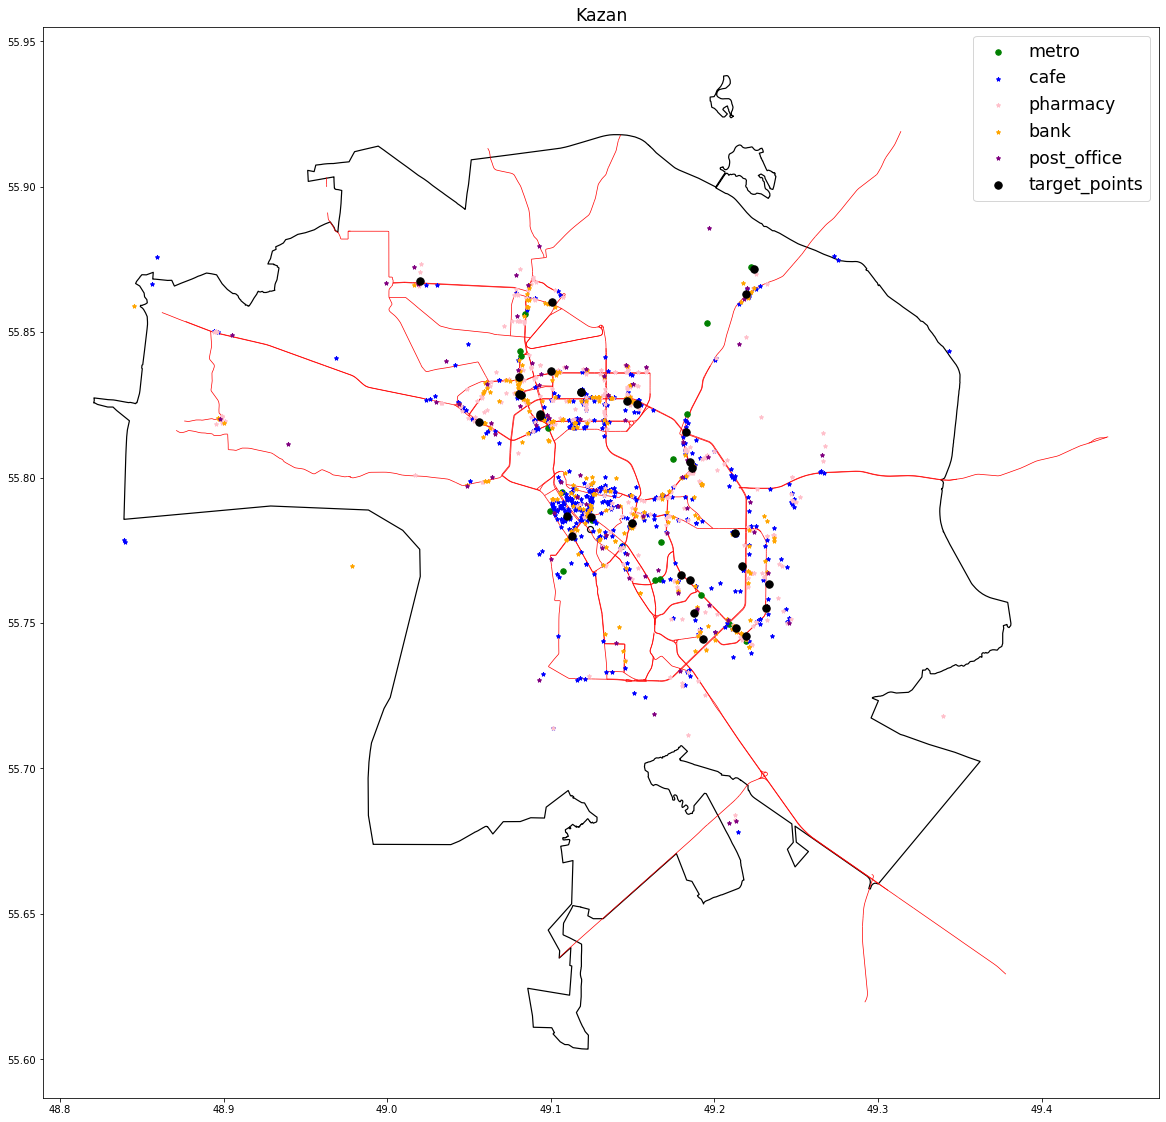

In [1968]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
kazan.plot(ax=ax, color='white', edgecolor='black', linewidth =1.2)
metro_kazan.plot(ax=ax, marker='o', color='green', markersize=30, legend='metro', zorder=2, label ='metro');
amenity_osm[amenity_osm['amenity'] == 'cafe'].plot(ax=ax, marker='*', color='blue', markersize=16, zorder=2, column="category", label ='cafe');
amenity_osm[amenity_osm['amenity'] == 'pharmacy'].plot(ax=ax, marker='*', color='pink', markersize=16, legend='metro', zorder=2, label ='pharmacy');
amenity_osm[amenity_osm['amenity'] == 'bank'].plot(ax=ax, marker='*', color='orange', markersize=16, legend='metro', zorder=2, label ='bank');
amenity_osm[amenity_osm['amenity'] == 'post_office'].plot(ax=ax, marker='*', color='purple', markersize=16, legend='metro', zorder=2, label ='post_office');
new_train.loc[new_train['NAME'] == 'Республика Татарстан (Татарстан)', 'geometry'].plot(ax=ax, marker='o', color='black', markersize=55, zorder=3, label ='target_points');
kazan_roands.plot(ax=ax, color='red', zorder=1, linewidth =0.7);

ax.legend(fontsize = 'xx-large')
ax.set_title('Kazan', fontsize = 'xx-large')

In [1971]:
lon_min = 43.6354
lat_min = 56.1410
lon_max = 44.3838
lat_max = 56.4113

nvg_bbox = lat_min,lon_min,lat_max,lon_max

overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
(node["amenity"]({},{},{},{});
);
out center;
'''.format(*nvg_bbox)

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
amenity = response.json()

amenity_osm = pd.DataFrame(amenity['elements'])

for i in range(amenity_osm.shape[0]):
    amenity_osm.loc[i, 'amenity'] = amenity_osm['tags'].values[i]['amenity']
amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
amenity_osm = gpd.GeoDataFrame(amenity_osm)
key = ['id', 'lat', 'lon', 'tags', 'type']
amenity_osm = amenity_osm.drop(key, axis = 1)

In [1972]:
nvg = gpd.read_file('export (18).geojson')
nvg_roads = gpd.read_file('export (20).geojson')

Text(0.5, 1.0, 'Nizhny Novgorod')

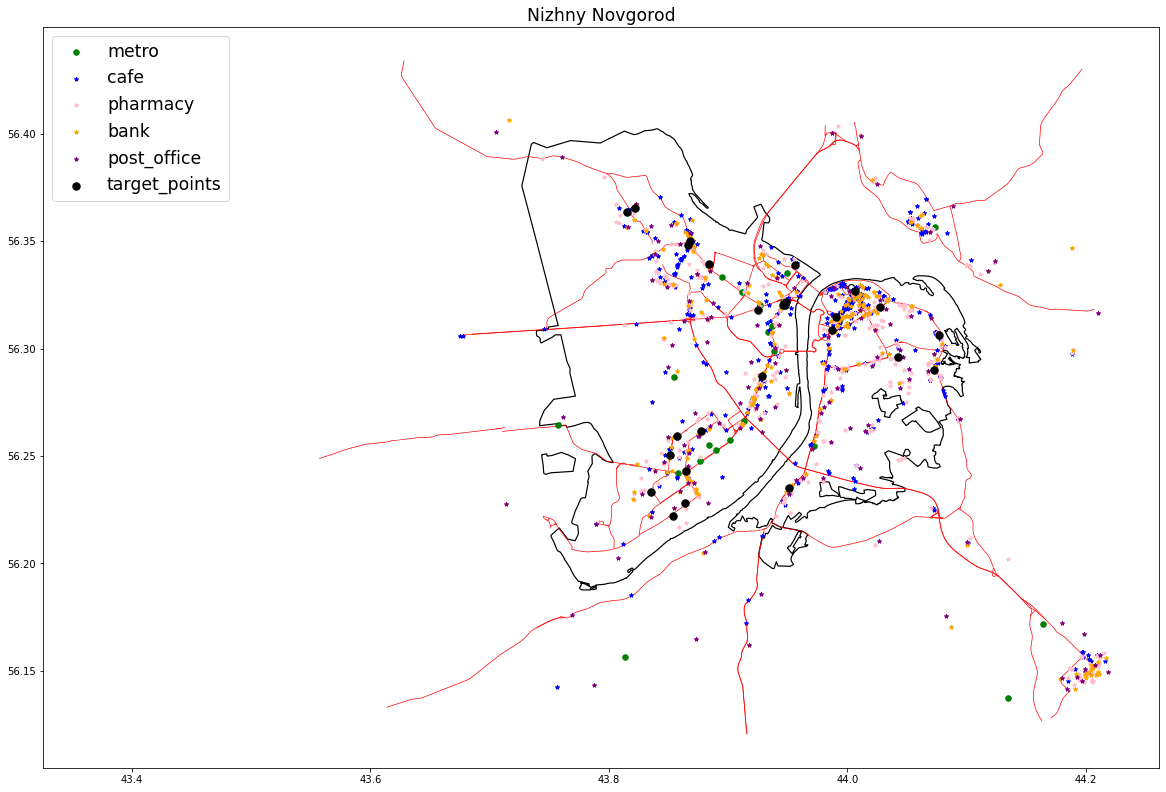

In [1974]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
nvg.plot(ax=ax, color='white', edgecolor='black', linewidth =1.2)
metro_nvg.plot(ax=ax, marker='o', color='green', markersize=30, legend='metro', zorder=2, label ='metro');
amenity_osm[amenity_osm['amenity'] == 'cafe'].plot(ax=ax, marker='*', color='blue', markersize=16, zorder=2, column="category", label ='cafe');
amenity_osm[amenity_osm['amenity'] == 'pharmacy'].plot(ax=ax, marker='*', color='pink', markersize=16, legend='metro', zorder=2, label ='pharmacy');
amenity_osm[amenity_osm['amenity'] == 'bank'].plot(ax=ax, marker='*', color='orange', markersize=16, legend='metro', zorder=2, label ='bank');
amenity_osm[amenity_osm['amenity'] == 'post_office'].plot(ax=ax, marker='*', color='purple', markersize=16, legend='metro', zorder=2, label ='post_office');
new_train.loc[new_train['NAME'] == 'Нижегородская область', 'geometry'].plot(ax=ax, marker='o', color='black', markersize=55, zorder=3, label ='target_points');
nvg_roads.plot(ax=ax, color='red', zorder=1, linewidth =0.7);

ax.legend(fontsize = 'xx-large', loc='upper left')
ax.set_title('Nizhny Novgorod', fontsize = 'xx-large')